# Predicting binary credit risking with deep learning models

The data set I am using in this notebook is the South German Credit Prediction data set from Kaggle.

## Set up environment

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras import regularizers
from sklearn.model_selection import train_test_split
import zipfile

## Data preparation

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
with zipfile.ZipFile('SouthGermanCredit.zip', 'r') as zip_ref:
    zip_ref.extractall('./SouthGermanCredit/')

--2021-06-27 15:32:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13130 (13K) [application/x-httpd-php]
Saving to: ‘SouthGermanCredit.zip.2’

SouthGermanCredit.z 100%[===================>]  12.82K  --.-KB/s    in 0s      

2021-06-27 15:32:07 (93.9 MB/s) - ‘SouthGermanCredit.zip.2’ saved [13130/13130]



In [3]:
df = pd.read_csv('./SouthGermanCredit/SouthGermanCredit.asc', sep=' ')
features = df.copy()
labels = features.pop('kredit')
trainX, testX, trainY, testY = train_test_split(features, labels, test_size=0.2, random_state=69)

## Helper functions

In [4]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(trainX))

test_results = {}

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.xlabel('Epoch')
  # plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

def plot_predictions(prediction):
  a = plt.axes(aspect='equal')
  plt.scatter(testY, prediction)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  # lims = [500, 1000]
  # plt.xlim([500, 1000])
  # plt.ylim([500, 1000])
  _ = plt.plot

def plot_accuracy(prediction):
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  testY_arr = testY.to_numpy()

  for x in range(200):
    # print(str(testY_arr[x]) + "; " + str(prediction[x]))
    # print("predict is : " + str(np.argmax(prediction[x])))
    if testY_arr[x] == 1:
      if np.argmax(prediction[x]) == 1:
        tp = tp + 1
      else:
        fn = fn + 1
    else:
      if np.argmax(prediction[x]) == 0:
        tn = tn + 1
      else:
        fp = fp + 1
  
  accuracy = (tp + tn)/(tp + fp + fn + tn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print("Accuracy: " + str(accuracy))
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  # print("Specificity: " + str(specificity))
  print("F-Measure: " + str(2*(recall * precision) / (recall + precision)))

# DNN Model

In [5]:
from tensorflow.keras import regularizers

batch_size=32
learning_rate=1e-3

model = tf.keras.Sequential([
      normalizer,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

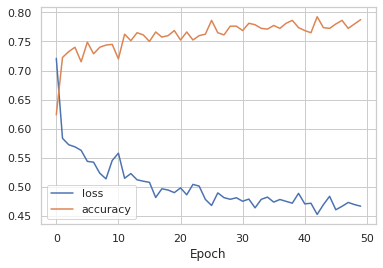

In [6]:
dnn_history = model.fit(trainX, trainY, epochs=50, verbose=0, batch_size=batch_size)
plot_loss(dnn_history)

In [7]:
test_loss, test_acc = model.evaluate(testX, testY, verbose=2)
# print('\nTest accuracy:', test_acc)

7/7 - 0s - loss: 0.5272 - accuracy: 0.7500


## Results

In [8]:
# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
dnn_predictions = model.predict(testX)
plot_accuracy(dnn_predictions)
from sklearn.metrics import roc_auc_score
print("AUC: {}".format(roc_auc_score(testY, dnn_predictions[:,1])))

Accuracy: 0.75
Precision: 0.7908496732026143
Recall: 0.8705035971223022
F-Measure: 0.8287671232876712
AUC: 0.7664818964500532
